# Neural Collaborative Based Filtering

- using neural network to learn the user-item interaction

This piece is a TensorFlow implementation of Neural Collaborative Filtering (NCF) from the paper [He et al. (2017)](https://arxiv.org/pdf/1708.05031.pdf).

## Summary

NCF uses neural networks to model the interactions between users and items. NCF replaces the inner product (used in ordinary MF methods) with a neural architecture that can learn an arbitrary function from data. This allows NCF to express and generalize matrix factorization under its framework. Essentially, it uses a neural network to learn the user-item interaction function, and uses the learned function to predict the corresponding rating. A multi-layer perceptron is used to learn the user-item interaction function. 


## Model 1: Ratings Only

The steps are as follows:

1. Read in Original Data
2. Remove some ratings to create the test set
3. With remaining ratings, create training set
4. Preprocess the data (melt the data, create user and item indices, normalize the ratings)
5. Create neural network model (NCF)
6. Train the model
7. Hyperparameter tuning
8. Evaluate the model on the test set
9. Gather all ratings prediction metrics (MAE, MSE, RMSE)

In [3]:
# reset space
%reset -f

# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')

# tensorflow libraries load
from tensorflow.keras.layers import Embedding, Input, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2


2024-02-29 23:48:55.125682: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/pavansingh/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [4]:
# load data
# amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set2_data_modelling.csv')
amz_data = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/set3_data_modelling.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))
print('Min number of ratings per user: ', amz_data['reviewerID'].value_counts().min())
print('Max number of ratings per user: ', amz_data['reviewerID'].value_counts().max())
print('Min number of ratings per product: ', amz_data['asin'].value_counts().min())
print('Max number of ratings per product: ', amz_data['asin'].value_counts().max())



# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())


,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249
Min number of ratings per user:  13
Max number of ratings per user:  193
Min number of ratings per product:  13
Max number of ratings per product:  189


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Creating Train and Test Sets

In [5]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating
24,A119Q9NFGVOEJZ,0767834739,5.0
39,A120UTHQDQIJGH,0767834739,1.0
157,A169I83JL8QJGN,0767834739,1.0
333,A1COW0UIB5HA9J,0767834739,5.0


Data is in format: user, product, rating.
It is ready to be partitioned into training and testing sets.


In [6]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))

Training Data


,user,product
24,24,0
39,39,0
157,157,0



Testing Data


,user,product
174,174,0
4473,805,1
4869,1201,1


### Creating NCF Model

Inputs:
user_input and product_input: These are integer inputs representing user and product IDs.
user_embedding and product_embedding: These layers create dense embeddings for users and products based on their IDs.
user_vecs and product_vecs: These flatten the embeddings to create feature vectors.
input_vecs: The concatenated feature vectors serve as the input to the neural network.
Neural Network Architecture:
You’ve designed a feedforward neural network with multiple layers.
The first layer (i == 0) has n_nodes neurons, followed by dropout regularization.
Subsequent layers reduce the number of neurons by halving n_nodes.
The final output layer predicts the rating (regression task).
Optimizers:
You’ve implemented three optimizers: Adam, SGD, and RMSprop.
The choice of optimizer affects how the model updates its weights during training.
Loss Function:
The mean squared error (MSE) loss is used for regression tasks.
The model aims to minimize the difference between predicted and actual ratings.
Training:
The model is trained using user and product IDs as input features.
The train_x dictionary contains user and product data.
The train_y array holds the corresponding ratings.
You’ve split the data into training and validation sets (10% validation split).

In [7]:
# Function to train a neural network model for collaborative filtering
def train_model_1(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg, train_x, train_y, seed=2207, train_plot=True, callback=True):
    
    # Set random seed
    np.random.seed(seed)

    # Create user and product embedding layers
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten the embedding vectors
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate the embedding vectors
    input_vecs = Concatenate()([user_vecs, product_vecs])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
    y = Dense(1)(x)

    # Compile the model
    model = Model(inputs=[user_input, product_input], outputs=y)
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Define early stopping
    if callback:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)

    # Train the model
    history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Figures/ncf_training_1.pdf")
        plt.show()
    
    return model, history

### Training NCF Model

- increasing batch size is good:128
- increase nodes
- change optimizer
- change learning rate

In [ ]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model, history = train_model_1(n_layers=2, n_nodes=512, optimizer='rmsprop', epochs=200, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model2, history2 = train_model_1(n_layers=3, n_nodes=512, optimizer='rmsprop', epochs=200, learning_rate=0.001, batch_size=128,dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model3, history3 = train_model_1(n_layers=4, n_nodes=512, optimizer='rmsprop', epochs=200, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

# Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model4, history4 = train_model_1(n_layers=5, n_nodes=512, optimizer='rmsprop', epochs=200, learning_rate=0.001, batch_size=128, dropout=0.5, l2_reg=0.01, train_x=train_x, train_y=train_y, seed=10, train_plot=False, callback=True)

In [90]:
# Which model had lowest validation loss?
print("Model 1 Validation Loss: ", min(history.history['val_loss']))
print("Model 2 Validation Loss: ", min(history2.history['val_loss']))
print("Model 3 Validation Loss: ", min(history3.history['val_loss']))
print("Model 4 Validation Loss: ", min(history4.history['val_loss']))

Model 1 Validation Loss:  0.05599355697631836
Model 2 Validation Loss:  0.05599347501993179
Model 3 Validation Loss:  0.05599348992109299
Model 4 Validation Loss:  0.05599628761410713


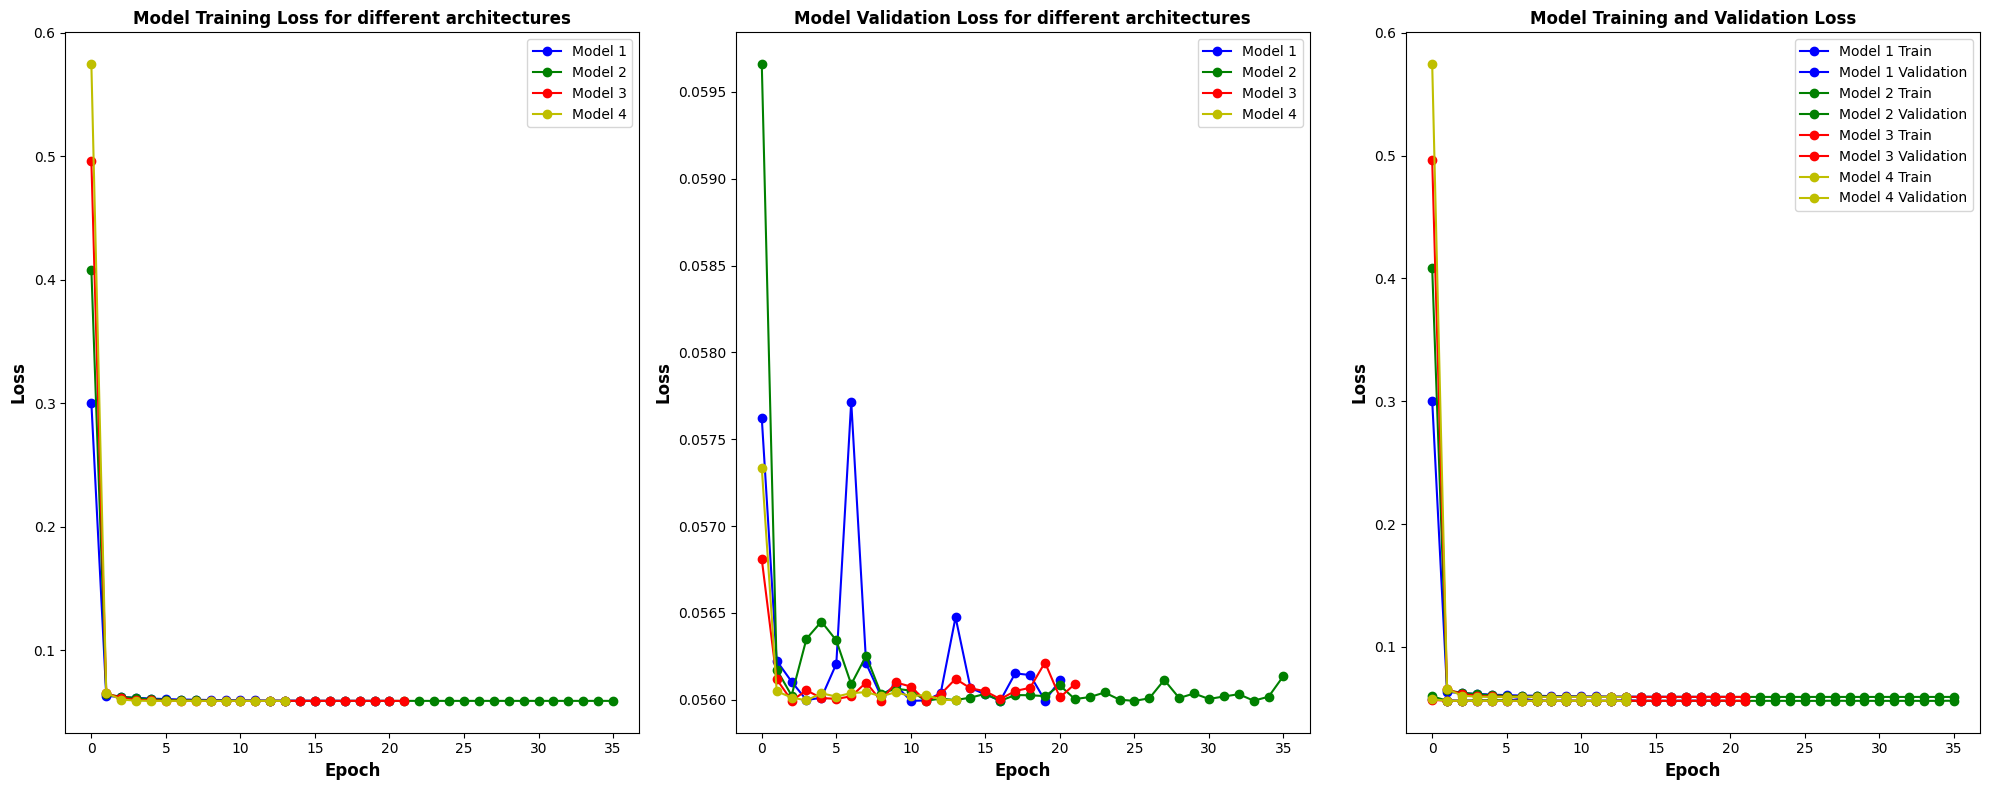

Model 1: 2 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size
Model 2: 3 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size
Model 3: 4 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size
Model 4: 5 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size


In [91]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print models
print("Model 1: 2 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size")
print("Model 2: 3 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size")
print("Model 3: 4 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size")
print("Model 4: 5 layers, 256 nodes, adam, 50 epochs, 0.001 learning rate, 128 batch size")


### Hyperparameter Tuning / Grid Search

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [2, 3, 6, 8] 
n_nodes = [512, 1024] 
optimizer = ['adam', 'sgd', 'rmsprop']
epochs = [40] 
learning_rate = [0.001, 0.01] 
batch_size = [128, 256] 
dropout = [0.2, 0.5]
l2 = [0.01, 0.1, 0.5]

print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)* len(dropout)* len(l2)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs, dropout, l2 = combination

        # Train the model
        model, history = train_model_1(n_layer, n_node, opt, epoch, lr, bs, dropout, l2, train_x, train_y, seed=10, train_plot=False, callback=True)

        # Evaluate the model
        min_loss = min(history.history['val_loss'])

        # Check if this model is better than the previous best
        if best_score is None or min_loss < best_score:
            best_score = min_loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y)
print(f"Best Parameters: {best_params}")

In [8]:
n_layers = 2
n_nodes = 256
optimizer = 'adam'
epochs = 50
learning_rate = 0.001
batch_size = 128
dropout = 0.5
l2_reg = 0.01

best_params = (n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg)
best_params

(2, 256, 'adam', 50, 0.001, 128, 0.5, 0.01)

Epoch 1/50


508/508 [==============================] - 4s 6ms/step - loss: 0.3362 - val_loss: 0.0562
Epoch 2/50
508/508 [==============================] - 2s 5ms/step - loss: 0.0615 - val_loss: 0.0527
Epoch 3/50
508/508 [==============================] - 2s 4ms/step - loss: 0.0541 - val_loss: 0.0517
Epoch 4/50
508/508 [==============================] - 2s 4ms/step - loss: 0.0503 - val_loss: 0.0502
Epoch 5/50
508/508 [==============================] - 2s 5ms/step - loss: 0.0475 - val_loss: 0.0499
Epoch 6/50
508/508 [==============================] - 3s 5ms/step - loss: 0.0459 - val_loss: 0.0512
Epoch 7/50
508/508 [==============================] - 3s 7ms/step - loss: 0.0444 - val_loss: 0.0497
Epoch 8/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0437 - val_loss: 0.0518
Epoch 9/50
508/508 [==============================] - 2s 5ms/step - loss: 0.0436 - val_loss: 0.0530
Epoch 10/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0429 - val_loss: 0.0491
Epoch 11/5

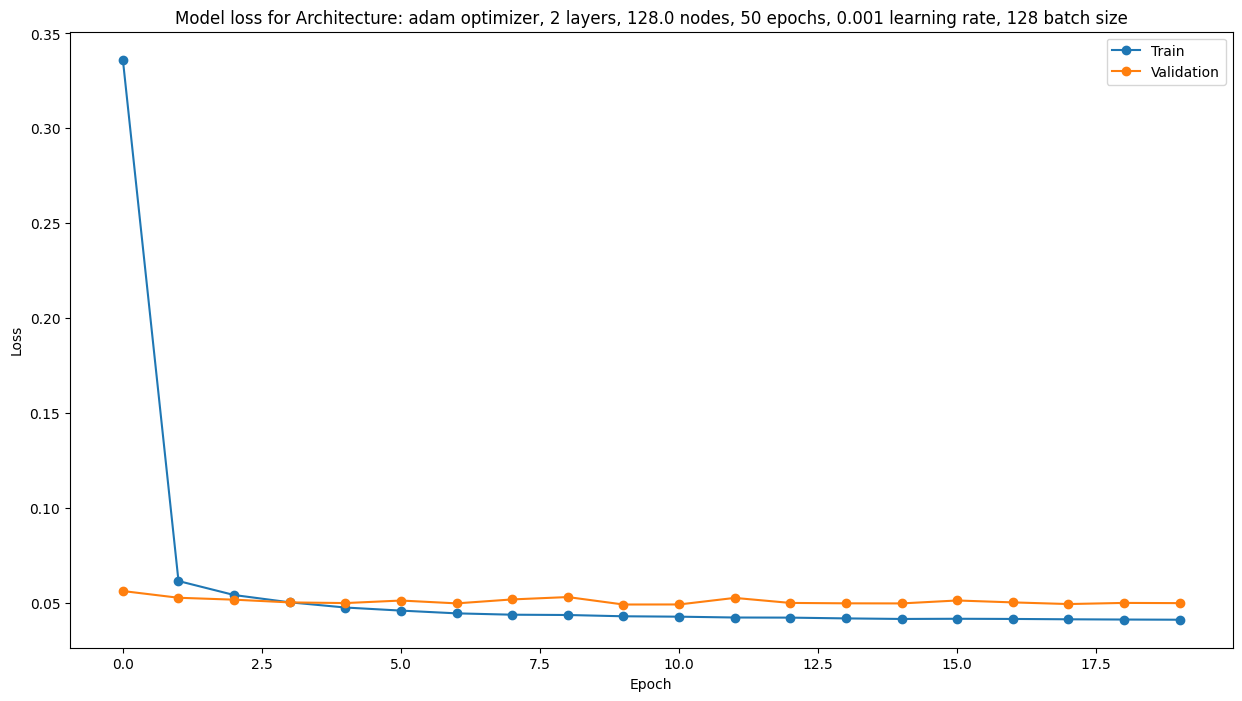

In [9]:
# fit best model 
best_model, history = train_model_1(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], dropout=best_params[6], l2_reg=best_params[7], train_x=train_x, train_y=train_y, train_plot=True, callback=True, seed=10)

### Evaluating NCF Model

In [10]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv(r"/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Results/NCF_results_1.csv", index=False)
results.index = ['NCF']
results

344/344 [==============================] - 1s 1ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.6328941388201255
Mean Squared Error (MSE): 0.8183657231449024
Root Mean Squared Error (RMSE): 0.9046356853147584


,MAE,MSE,RMSE
NCF,0.633,0.818,0.905


### Top-N Recommendations



In [42]:
data_mat = data.copy()
data_mat = data_mat.reset_index()
data_mat = data_mat.melt(id_vars=data_mat.columns[0], var_name='product', value_name='rating')
data_mat.columns = ['user', 'product', 'rating']
data_mat['user'] = data_mat['user'].astype('category')
data_mat['product'] = data_mat['product'].astype('category')
data_mat['user'] = data_mat['user'].cat.codes
data_mat['product'] = data_mat['product'].cat.codes
display(data_mat.head(3))

,user,product,rating
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN


In [43]:
def fill_nan_ratings_with_predictions(model, data):
    # Create a copy of the DataFrame to avoid modifying the original
    completed = data.copy()

    # Find rows with NaN ratings
    nan_rows = completed[completed['rating'].isna()]

    # Predict the ratings for these rows
    predictions = model.predict([nan_rows['user'], nan_rows['product']])
    predictions = predictions * 4 + 1

    # Fill in the predictions
    completed.loc[nan_rows.index, 'rating'] = predictions.flatten()

    return completed

# Fill NaN ratings with predictions
completed = fill_nan_ratings_with_predictions(model=best_model, data=data_mat)

369819/369819 [==============================] - 369s 999us/step


In [44]:
data_mat.head(3)

,user,product,rating
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN


In [46]:
completed.head(3)

,user,product,rating
0,0,0,4.062672
1,1,0,3.607499
2,2,0,4.081617


In [140]:
print("Test Data: X")
display(test_x.head(3))

# Define the threshold for positive interaction
test_y_top_n = test_y.copy()
test_y_top_n = pd.DataFrame(test_y_top_n)
test_y_top_n = test_y_top_n* 4 + 1

# Now, test_y will have a 'label' column with 0 for negative interactions and 1 for positive interactions
print("Test Data: Y")
display(test_y_top_n.head(3))

# predicted data
print("Predicted Data")
predicted_rats = pd.Series(predicted_ratings_array)
predicted_rats.index = test_y.index
display(predicted_rats.head(3))



Test Data: X


,user,product
174,174,0
4473,805,1
4869,1201,1


Test Data: Y


,rating
174,3.0
4473,5.0
4869,5.0


Predicted Data


174     3.862601
4473    4.700298
4869    4.760379
dtype: float32

In [154]:
# Function to calculate top-N metrics
def top_n_evaluation(test_x, test_y, predicted_ratings, N):
    """
    Evaluate a recommender system using Top-N metrics (NDCG and Hit Rate).

    Args:
        test_x (pd.DataFrame): Test set containing user and product columns.
        test_y (pd.Series): Test set containing actual ratings (between 1 and 5).
        predicted_ratings (pd.Series): Predicted ratings for each user-item pair.
        N (int, optional): The number of top items to consider (default is 10).

    Returns:
        float: NDCG score for the recommendation system.
        float: Hit Rate (proportion of users with at least one relevant item in top-N).
    """
    ndcg_sum = 0.0
    hit_count = 0
    num_users = len(test_x)

    for _, row in test_x.iterrows():
        user_id, item_id = row["user"], row["product"]
        if user_id not in predicted_ratings.index:
            continue

        predicted_rating = predicted_ratings.loc[user_id]

        # Sort items by predicted ratings (descending order)
        sorted_items = predicted_ratings.sort_values(ascending=False).index
        top_n_items = sorted_items[:N]

        # Calculate NDCG
        true_rating = test_y.loc[user_id]
        true_scores = np.array([1.0 if item_id == item else 0.0 for item in top_n_items])
        dcg = np.sum(true_scores / np.log2(np.arange(2, N + 2)))

        # Calculate ideal DCG (perfect ranking)
        ideal_scores = np.sort(true_scores)[::-1]
        ideal_dcg = np.sum(ideal_scores / np.log2(np.arange(2, N + 2)))

        # Update NDCG sum
        ndcg_sum += dcg / ideal_dcg

        # Check if true item is in top-N
        if item_id in top_n_items:
            hit_count += 1

    # Average NDCG across all users
    average_ndcg = ndcg_sum / num_users
    hit_rate = hit_count / num_users

    return average_ndcg, hit_rate, N

In [156]:
ndcg_score, hit_rate, N = top_n_evaluation(test_x=test_x, test_y=test_y_top_n, predicted_ratings=predicted_rats, N=100)
print(f"NDCG@{N}: {ndcg_score:.4f}")
print(f"Hit Rate: {hit_rate:.4f}")



NDCG@100: nan
Hit Rate: 0.0000


***
## Model 2: Ratings + Reviews

In [42]:
# load data
# amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set3_data_modelling.csv')
amz_data = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/set3_data_modelling.csv')
text_embeddings = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Word Embeddings

- https://www.kaggle.com/models/google/universal-sentence-encoder/frameworks/tensorFlow2/variations/universal-sentence-encoder/versions/2?tfhub-redirect=true

In [93]:
# import tensorflow as tf
# import tensorflow_hub as hub

# # load the model for sentence embeddings
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# sent_model = hub.load(module_url)
# print(f"Module {module_url} loaded")

# # Embedding review text
# print("Applying the Universal Sentence Encoder on the review text...")
# review_text = amz_data['reviewText']  # Replace with your actual column name
# text_embeddings = sent_model(review_text)
# print("Review text embeddings generated!")
# print(f"Shape of Text Embeddings: {text_embeddings.shape}")

# # attach embeddings to dataframe
# text_embeddings = text_embeddings.numpy()
# text_embeddings = pd.DataFrame(text_embeddings)
# text_embeddings['revText'] = amz_data['reviewText']
# text_embeddings['asin'] = amz_data['asin']
# text_embeddings['reviewerID'] = amz_data['reviewerID']
display(text_embeddings.head(4))

Module https://tfhub.dev/google/universal-sentence-encoder/4 loaded
Applying the Universal Sentence Encoder on the review text...
Review text embeddings generated!
Shape of Text Embeddings: (83139, 512)


,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,revText,asin,reviewerID
0,-0.011411,0.012732,0.012249,-0.029770,0.032968,0.066360,-0.015612,-0.003035,-0.016978,0.029414,...,0.062207,-0.035347,0.011524,-0.036790,-0.030792,0.104588,0.000913,wonderful movie,0767834739,AQ8OO59DJFJNZ
1,0.016304,0.052245,-0.044929,-0.003093,0.030458,-0.015125,0.063519,-0.023906,0.013280,-0.034587,...,-0.061882,-0.062525,-0.012602,-0.040133,-0.000692,0.068579,0.023263,resident evil is a great science fictionhorror...,0767834739,A244CRJ2QSVLZ4
2,0.003858,0.014974,0.003381,-0.023209,0.053806,-0.059621,0.050380,-0.010782,-0.069886,-0.072230,...,0.004721,-0.043190,-0.042796,0.008850,-0.054297,0.075987,0.062721,i this movie has people living and working und...,0767834739,A1VCLTAGM5RLND
3,-0.003534,-0.056638,-0.049522,-0.006381,0.007624,0.006230,0.037928,-0.059353,-0.064795,-0.009551,...,0.058787,-0.064053,-0.006464,0.064920,-0.062360,0.065526,-0.062345,every single video game based movie from the s...,0767834739,A119Q9NFGVOEJZ


#### Training and Test Sets

In [45]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')

# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# add text embeddings to the data (match user and product to the embeddings)
data_hidden = pd.merge(data_hidden, text_embeddings, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating, text embeddings.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,A100RH4M1W1DF0,B001NJJOCW,5.0,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,A100RH4M1W1DF0,B003SIOXTA,5.0,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,A100RH4M1W1DF0,B003ZXCAAC,5.0,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203
3,A100RH4M1W1DF0,B00AA8WPGY,5.0,-0.041756,-0.010512,0.014876,-0.018273,-0.043437,-0.015833,-0.048072,...,0.008394,0.021828,0.048689,-0.000628,-0.007572,0.048054,0.008952,0.060675,0.000830,0.021475


Data is in format: user, product, rating, text embeddings.
It is ready to be partitioned into training and testing sets.


In [3]:
# # save data 
# data_hidden.to_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/data_hidden.csv', index=False)    
# text_embeddings.to_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv', index=False)

# load data
# data_hidden = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/data_hidden.csv')
# text_embeddings = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv')

# data_hidden['user'] = data_hidden['user'].astype('category')
# data_hidden['product'] = data_hidden['product'].astype('category')



In [46]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# add text embeddings to the training data (merge on index)
train_x = pd.merge(train_x, data_hidden, how='outer', left_index=True, right_index=True)
train_x.drop(['user_y', 'product_y', 'rating'], axis=1, inplace=True)
train_x.rename(columns={'user_x': 'user', 'product_x': 'product'}, inplace=True)

# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]


# add text embeddings to the testing data (merge on user and product)
test_x = pd.merge(test_x, text_embeddings, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')

# use cat codes to convert to numerical (for user and product)
test_x['user'] = test_x['user'].cat.codes
test_x['product'] = test_x['product'].cat.codes
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))

Training Data


,user,product,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,0,993,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,0.019613,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,0,1189,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,0.019613,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,0,1203,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,0.019240,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203



Testing Data


,user,product,0,1,2,3,4,5,6,7,...,502,503,504,505,506,507,508,509,510,511
0,174,0,0.039119,-0.059384,-0.027734,-0.032066,0.045529,0.051033,0.016597,-0.020671,...,-0.011423,-0.062120,0.006031,-0.036203,-0.060012,0.018534,0.053185,0.039681,0.062120,0.057558
1,805,1,0.033977,-0.053225,-0.040635,-0.042631,0.037649,-0.014275,0.010381,-0.050364,...,-0.019601,-0.061564,0.051966,0.011331,-0.046066,0.058120,0.050817,0.058296,0.061771,0.019092
2,1201,1,0.045144,-0.061331,-0.039053,0.068657,0.053297,-0.012607,-0.045700,0.023360,...,-0.004607,-0.074282,-0.033336,-0.017320,0.036439,0.029585,-0.000270,0.003543,0.074316,0.049292


#### NCF Model with Reviews


**Inputs:**
You have three input layers:
- `user_input`: Represents the user ID (integer).
- `product_input`: Represents the product ID (integer).
- `text_input`: Represents the text embeddings of user reviews (float32).

**Embeddings:**
You create embeddings for users and products using the Embedding layer. These embeddings are essential for capturing latent features.
- `user_embedding`: Embedding for user IDs.
- `product_embedding`: Embedding for product IDs.

**Flattening and Concatenation**:
You flatten the user and product embeddings to create vectors (`user_vecs` and `product_vecs`).
Then, you concatenate these vectors with the text embeddings (`text_input`) to form the combined input vector (`input_vecs`).

**Hidden Layers:**
You use a loop to create hidden layers:
For the first layer (i == 0), you apply a Dense layer with ReLU activation and dropout.
For subsequent layers, you reduce the number of nodes by half and apply the same architecture.

**Output Layer**:
The final output layer (*y*) predicts the user-item interaction (*rating*).

**Model Compilation**:
You compile the model using the specified optimizer (Adam, SGD, or RMSprop) and the mean squared error (MSE) loss.

**Training:**
The model is trained using user and product data (`train_x['user']` and `train_x['product']`) along with the target variable (`train_y`).
You split the data into training and validation sets (10% validation split).

**Return:**
The function returns the trained model and training history.

In [47]:
# Function to train a neural network model for collaborative filtering with text embeddings
def train_model_2(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg, train_x, train_y, text_embedding_dim, seed=2207, train_plot=True, callback=True):
    np.random.seed(seed)

    # Inputs
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input') 

    # Embeddings
    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate user, product, and text embeddings
    input_vecs = Concatenate()([user_vecs, product_vecs, text_input])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
    y = Dense(1)(x)

    # Compile and train the model
    model = Model(inputs=[user_input, product_input, text_input], outputs=y)

    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Define early stopping
    if callback:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


    # Train the model
    history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 2:]], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

    # Plot training & validation loss values
    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Figures/ncf_training_2.pdf")
        plt.show()
    
    return model, history


In [48]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model, history = train_model_2(n_layers=2, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,  seed=10, train_plot=False, callback = True)

# # Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model2, history2 = train_model_2(n_layers=3, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,seed=10, train_plot=False, callback = True)

# # Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model3, history3 = train_model_2(n_layers=4, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,seed=10, train_plot=False, callback = True)

# # Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
# print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
# model4, history4 = train_model_2(n_layers=5, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,seed=10, train_plot=False, callback = True)

Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Epoch 1/200
508/508 [==============================] - 5s 8ms/step - loss: 0.5164 - val_loss: 0.0569
Epoch 2/200
508/508 [==============================] - 5s 10ms/step - loss: 0.0523 - val_loss: 0.0565
Epoch 3/200
508/508 [==============================] - 4s 9ms/step - loss: 0.0477 - val_loss: 0.0517
Epoch 4/200
508/508 [==============================] - 5s 10ms/step - loss: 0.0456 - val_loss: 0.0517
Epoch 5/200
508/508 [==============================] - 5s 10ms/step - loss: 0.0431 - val_loss: 0.0492
Epoch 6/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0423 - val_loss: 0.0505
Epoch 7/200
508/508 [==============================] - 5s 10ms/step - loss: 0.0412 - val_loss: 0.0488
Epoch 8/200
508/508 [==============================] - 4s 9ms/step - loss: 0.0405 - val_loss: 0.0482
Epoch 9/200
508/508 [==============================] - 4s 9ms/step - loss: 0.0400 - val_loss: 0.0525
Epoc

#### Training Results

In [49]:
# Which model had lowest validation loss?
print("Model 1 Validation Loss: ", min(history.history['val_loss']))
# print("Model 2 Validation Loss: ", min(history2.history['val_loss']))
# print("Model 3 Validation Loss: ", min(history3.history['val_loss']))
# print("Model 4 Validation Loss: ", min(history4.history['val_loss']))

Model 1 Validation Loss:  0.044692184776067734


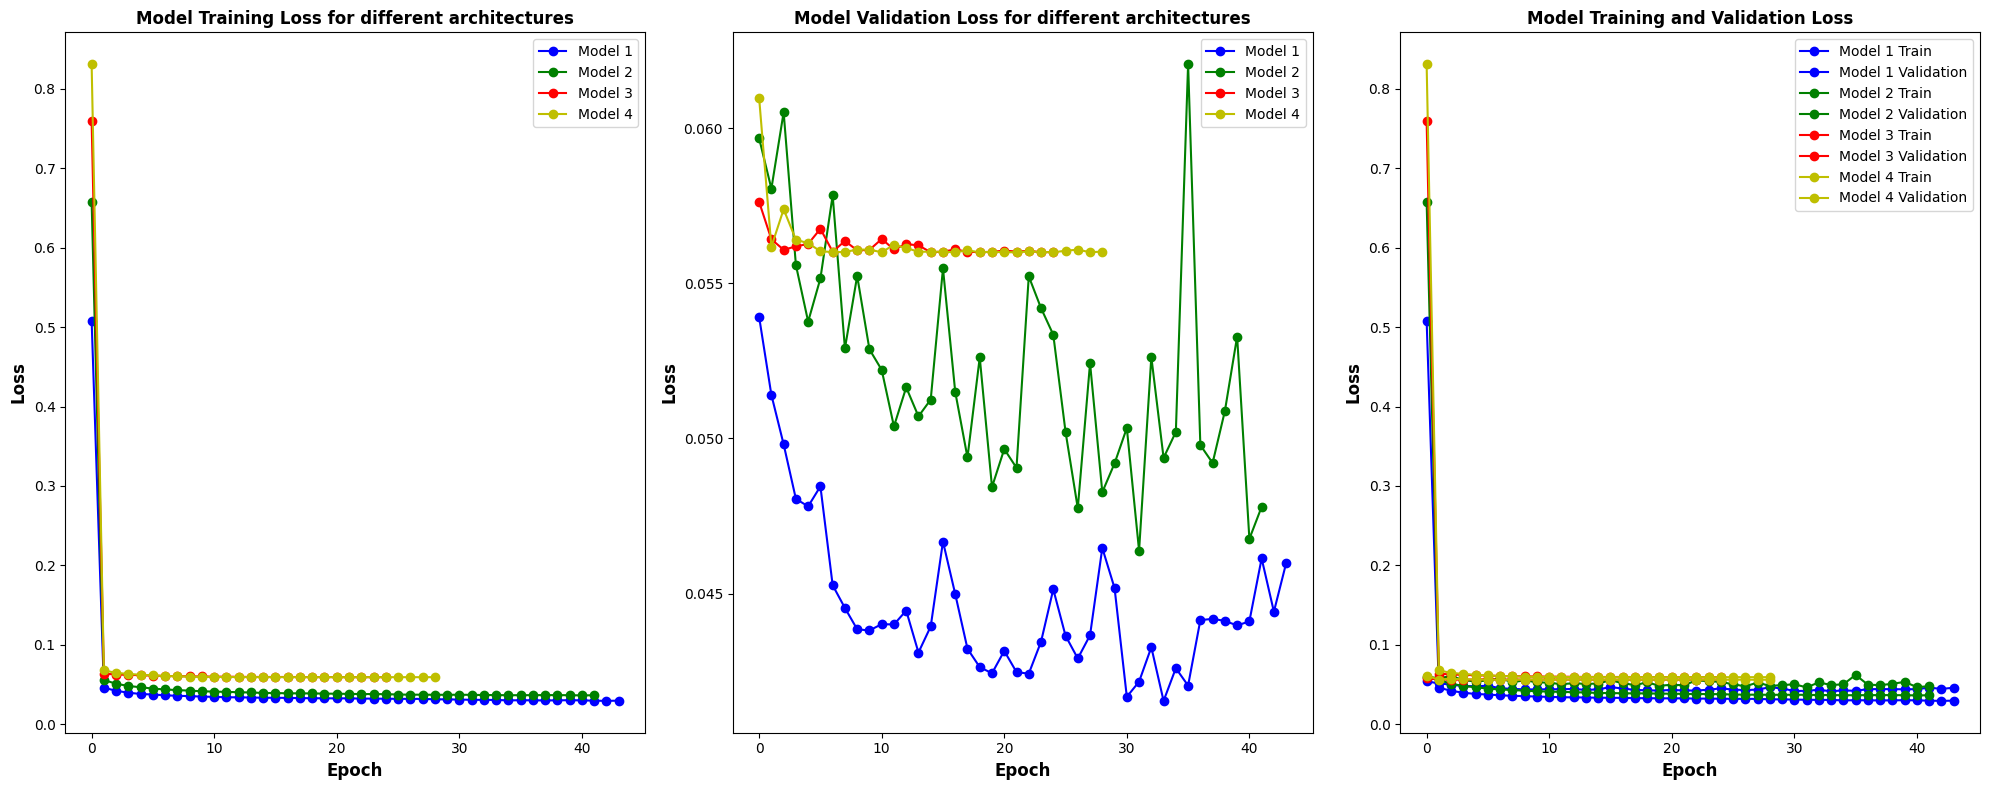

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [117]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")


### Hyperparameter Tuning / Grid Search

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [2]
n_nodes = [512]
optimizer = ['adam']
epochs = [200]
learning_rate = [0.1]
batch_size = [128]
dropout_val = [0.3]
l2_val = [0.01]

# print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)* len(dropout)* len(l2)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout_val, l2_val, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout_val, l2_val)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs, dropout_val, l2_val = combination
        print(combination)

        # Train the model
        model, history = train_model_2(n_layers=n_layer, n_nodes=n_node, optimizer=opt, epochs=epoch, learning_rate=lr, batch_size=bs, dropout=dropout_val, l2_reg=l2_val, train_x=train_x, train_y=train_y, train_plot=False, seed=10, text_embedding_dim = text_embeddings.shape[1]-3, callback=True)

        # Evaluate the model
        min_loss = min(history.history['val_loss'])

        # Check if this model is better than the previous best
        if best_score is None or min_loss < best_score:
            best_score = min_loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout_val, l2_val, train_x, train_y)
print(f"Best Parameters: {best_params}")

In [118]:
n_layers = 2
n_nodes = 512
optimizer = 'adam'
epochs = 200
learning_rate = 0.001
batch_size = 128
dropout = 0.5
l2_reg = 0.01

best_params = (2, 256, 'adam', 50, 0.001, 128, 0.5, 0.01)
best_params


(2, 256, 'adam', 50, 0.001, 128, 0.5, 0.01)

Epoch 1/50
508/508 [==============================] - 5s 7ms/step - loss: 0.4059 - val_loss: 0.0525
Epoch 2/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0477 - val_loss: 0.0545
Epoch 3/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0435 - val_loss: 0.0503
Epoch 4/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0412 - val_loss: 0.0489
Epoch 5/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0395 - val_loss: 0.0474
Epoch 6/50
508/508 [==============================] - 4s 8ms/step - loss: 0.0385 - val_loss: 0.0467
Epoch 7/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0375 - val_loss: 0.0459
Epoch 8/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0367 - val_loss: 0.0460
Epoch 9/50
508/508 [==============================] - 3s 6ms/step - loss: 0.0364 - val_loss: 0.0458
Epoch 10/50
508/508 [==============================] - 4s 7ms/step - loss: 0.0356 - val_loss: 0.0447

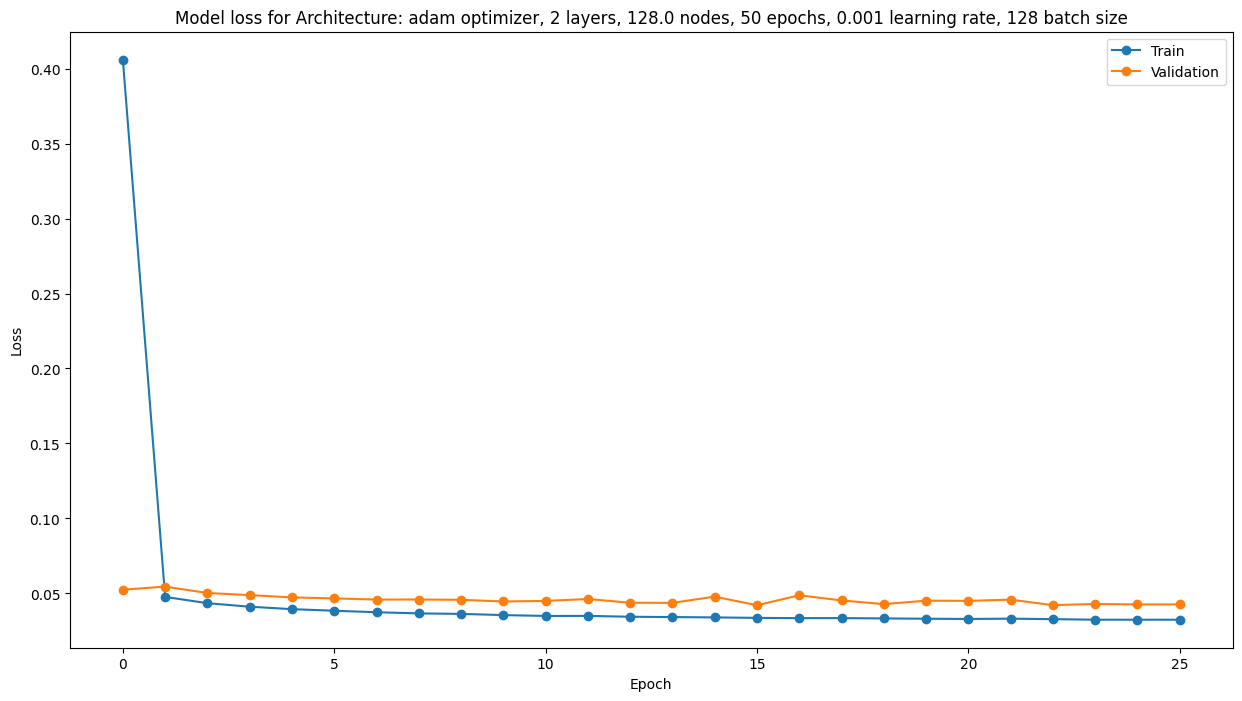

In [119]:
# fit best model 
best_model, history = train_model_2(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], dropout=best_params[6], l2_reg=best_params[7], train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, train_plot=True, callback=True, seed=10)

### Evaluation

In [120]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 2:]])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv(r"/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Results/NCF_results_2.csv", index=False)
results

344/344 [==============================] - 1s 3ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.5455559052713824
Mean Squared Error (MSE): 0.5906015878257777
Root Mean Squared Error (RMSE): 0.7685060753343318


,MAE,MSE,RMSE
0,0.546,0.591,0.769


## Model 3: Ratings + Reviews + Sentiments 

In [21]:
# load data
# amz_data = pd.read_csv(r'C:\Users\e1002902\Documents\GitHub Repository\Masters-Dissertation\Code\Data\set2_data_modelling.csv')
amz_data = pd.read_csv('/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/set3_data_modelling.csv')
text_embeddings = pd.read_csv(r'/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/NCF Data/text_embeddings.csv')
display(amz_data.head())

# print details
print('Number of Rows: ', amz_data.shape[0])
print('Number of Columns: ', amz_data.shape[1])
print('Number of Unique Users: ', len(amz_data['reviewerID'].unique()))
print('Number of Unique Products: ', len(amz_data['asin'].unique()))


# Creating User Item Matrix =====================================================
# create user-item matrix
data = amz_data.pivot_table(index='reviewerID', columns='asin', values='overall')
print("\n\nUser-Item Matrix")
display(data.head())

,reviewerID,reviewTime,asin,overall,reviewText,stemmed_words_revText,lemmatised_reviewText,filtered_tokens_revText,sentiments_afinn,sentiments_bing,sentiments_vader
0,AQ8OO59DJFJNZ,2018-01-05,0767834739,5.0,wonderful movie,wonder movi,wonderful movie,wonderful movie,4,1,0.5719
1,A244CRJ2QSVLZ4,2008-01-29,0767834739,5.0,resident evil is a great science fictionhorror...,resid evil great scienc fictionhorror hybrid p...,resident evil great science fictionhorror hybr...,resident evil great science fictionhorror hybr...,-12,-5,-0.9455
2,A1VCLTAGM5RLND,2005-07-23,0767834739,5.0,i this movie has people living and working und...,movi peopl live work underground place call hi...,movie people living working underground place ...,movie people living working underground place ...,-1,0,-0.1806
3,A119Q9NFGVOEJZ,2016-02-13,0767834739,5.0,every single video game based movie from the s...,everi singl video game base movi super mario b...,every single video game based movie super mari...,every single video game based movie super mari...,18,6,0.9846
4,A1RP6YCOS5VJ5I,2006-09-26,0767834739,5.0,i think that i like this movie more than the o...,think like movi origin origin still great real...,think like movie original original still great...,think like movie original original still great...,29,10,0.9951


Number of Rows:  83139
Number of Columns:  11
Number of Unique Users:  3668
Number of Unique Products:  3249


User-Item Matrix


asin,0767834739,7799146915,B00000DMAT,B00000DMAX,B00000DMB3,B00000F1GM,B00000I1BJ,B00000I1BY,B00000ID61,B00000INR2,...,B01H353FLA,B01H353HUY,B01H3VFR6U,B01H5GB8ZW,B01H6OXQFS,B01H9SH2LU,B01HGBAFNC,B01HHVVLGQ,B01HHVWWMI,B01HIZF7XE
reviewerID,,,,,,,,,,,,,,,,,,,,,
A100RH4M1W1DF0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
A1027EV8A9PV1O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A103KKI1Y4TFNQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A1047P9FLHTDZJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Word Embeddings

In [22]:
# import tensorflow as tf
# import tensorflow_hub as hub

# # load the model for sentence embeddings
# module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
# sent_model = hub.load(module_url)
# print(f"Module {module_url} loaded")

# # Embedding review text
# print("Applying the Universal Sentence Encoder on the review text...")
# review_text = amz_data['reviewText']  # Replace with your actual column name
# text_embeddings = sent_model(review_text)
# print("Review text embeddings generated!")
# print(f"Shape of Text Embeddings: {text_embeddings.shape}")

# # attach embeddings to dataframe
# text_embeddings = text_embeddings.numpy()
# text_embeddings = pd.DataFrame(text_embeddings)
# text_embeddings['revText'] = amz_data['reviewText']
# text_embeddings['asin'] = amz_data['asin']
# text_embeddings['reviewerID'] = amz_data['reviewerID']
display(text_embeddings.head(4))

,0,1,2,3,4,5,6,7,8,9,...,505,506,507,508,509,510,511,revText,asin,reviewerID
0,-0.011411,0.012732,0.012249,-0.029770,0.032968,0.066360,-0.015612,-0.003035,-0.016978,0.029414,...,0.062207,-0.035347,0.011524,-0.036790,-0.030792,0.104588,0.000913,wonderful movie,0767834739,AQ8OO59DJFJNZ
1,0.016304,0.052245,-0.044929,-0.003093,0.030458,-0.015125,0.063519,-0.023906,0.013280,-0.034587,...,-0.061882,-0.062525,-0.012602,-0.040133,-0.000692,0.068579,0.023263,resident evil is a great science fictionhorror...,0767834739,A244CRJ2QSVLZ4
2,0.003858,0.014974,0.003381,-0.023209,0.053806,-0.059621,0.050380,-0.010782,-0.069886,-0.072230,...,0.004721,-0.043190,-0.042796,0.008850,-0.054297,0.075987,0.062721,i this movie has people living and working und...,0767834739,A1VCLTAGM5RLND
3,-0.003534,-0.056638,-0.049522,-0.006381,0.007624,0.006230,0.037928,-0.059353,-0.064795,-0.009551,...,0.058787,-0.064053,-0.006464,0.064920,-0.062360,0.065526,-0.062345,every single video game based movie from the s...,0767834739,A119Q9NFGVOEJZ


#### Sentiment Scores

In [23]:
sentiments = amz_data[['reviewerID', 'asin','sentiments_vader']]
sentiments.columns = ['reviewerID', 'asin', 'sentiments']
display(sentiments.head(3))

,reviewerID,asin,sentiments
0,AQ8OO59DJFJNZ,0767834739,0.5719
1,A244CRJ2QSVLZ4,0767834739,-0.9455
2,A1VCLTAGM5RLND,0767834739,-0.1806


In [24]:
# DATA PREP ====================================

# create a copy of the original matrix to store hidden ratings
x_hidden = data.copy()
indices_tracker = []

# number of products to hide for each user
N = 3

# identifies rated items and randomly selects N products to hide ratings for each user
np.random.seed(2207)  # You can use any integer value as the seed
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

# get indices of hidden ratings
test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

In [29]:
# Melt the DataFrame into a format where each row is a user-item interaction
data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')


# change rows with hidden ratings to NaN
data_hidden.iloc[indices_hidden, 2] = np.nan

# rename columns
data_hidden.columns = ['user', 'product', 'rating']

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# add sentiments
data_hidden = pd.merge(data_hidden, sentiments, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['asin','reviewerID'], axis=1, inplace=True)

# add text embeddings to the data (match user and product to the embeddings)
data_hidden = pd.merge(data_hidden, text_embeddings, how='outer', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
data_hidden.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)

# Filter out the rows where rating is NaN
data_hidden = data_hidden[data_hidden['rating'].notna()]

# Convert user and item to categorical
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

# see what the data looks like
display(data_hidden.head(4))
print("Data is in format: user, product, rating, sentiments, text embeddings.\nIt is ready to be partitioned into training and testing sets.")

,user,product,rating,sentiments,0,1,2,3,4,5,...,502,503,504,505,506,507,508,509,510,511
0,A100RH4M1W1DF0,B001NJJOCW,5.0,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,A100RH4M1W1DF0,B003SIOXTA,5.0,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,A100RH4M1W1DF0,B003ZXCAAC,5.0,0.5859,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203
3,A100RH4M1W1DF0,B00AA8WPGY,5.0,-0.7269,-0.041756,-0.010512,0.014876,-0.018273,-0.043437,-0.015833,...,0.008394,0.021828,0.048689,-0.000628,-0.007572,0.048054,0.008952,0.060675,0.000830,0.021475


Data is in format: user, product, rating, sentiments, text embeddings.
It is ready to be partitioned into training and testing sets.


#### Train and Test Splits

In [30]:
# TEST AND TRAIN DATA ====================================

# Prepare the data - trining
train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

# add text embeddings to the training data (merge on index)
train_x = pd.merge(train_x, data_hidden, how='outer', left_index=True, right_index=True)
train_x.drop(['user_y', 'product_y', 'rating'], axis=1, inplace=True)
train_x.rename(columns={'user_x': 'user', 'product_x': 'product'}, inplace=True)
train_x


# Prepare the data - testing
copy = data.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]

# add sentiments to the testing data
test_x = pd.merge(test_x, sentiments, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['asin','reviewerID'], axis=1, inplace=True)

# add text embeddings to the testing data (merge on user and product)
test_x = pd.merge(test_x, text_embeddings, how='left', left_on=['user', 'product'], right_on=['reviewerID', 'asin'])
test_x.drop(['revText', 'asin','reviewerID'], axis=1, inplace=True)
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')

# use cat codes to convert to numerical (for user and product)
test_x['user'] = test_x['user'].cat.codes
test_x['product'] = test_x['product'].cat.codes
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

# show the data
print("Training Data")
display(train_x.head(3))

print("\nTesting Data")
display(test_x.head(3))


Training Data


,user,product,sentiments,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,0,993,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
1,0,1189,0.6369,0.035334,0.013374,-0.037586,0.013679,0.035644,-0.010553,-0.042595,...,-0.002809,-0.094814,0.009468,0.056684,-0.006769,0.062040,0.060013,-0.008133,-0.027617,0.017606
2,0,1203,0.5859,-0.009528,-0.077318,-0.078732,-0.022566,0.020784,0.040238,0.036082,...,-0.001551,-0.000948,-0.083168,0.060334,0.077315,-0.022964,0.076978,-0.033895,0.033755,0.004203



Testing Data


,user,product,sentiments,0,1,2,3,4,5,6,...,502,503,504,505,506,507,508,509,510,511
0,174,0,0.9907,0.039119,-0.059384,-0.027734,-0.032066,0.045529,0.051033,0.016597,...,-0.011423,-0.062120,0.006031,-0.036203,-0.060012,0.018534,0.053185,0.039681,0.062120,0.057558
1,805,1,0.8604,0.033977,-0.053225,-0.040635,-0.042631,0.037649,-0.014275,0.010381,...,-0.019601,-0.061564,0.051966,0.011331,-0.046066,0.058120,0.050817,0.058296,0.061771,0.019092
2,1201,1,0.9574,0.045144,-0.061331,-0.039053,0.068657,0.053297,-0.012607,-0.045700,...,-0.004607,-0.074282,-0.033336,-0.017320,0.036439,0.029585,-0.000270,0.003543,0.074316,0.049292


#### NCF Model with Reviews + Sentiments

In [31]:
# Function to train a neural network model for collaborative filtering with text embeddings
def train_model_3(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg, train_x, train_y, text_embedding_dim, seed=2207, train_plot=True, callback=True):
    np.random.seed(seed)

    # Inputs
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input') 
    sentiment_input = Input(shape=(1,), dtype='float32', name='sentiment_input')  # Sentiment scores

    # Embeddings
    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    # Flatten
    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    # Concatenate user, product, and text embeddings
    input_vecs = Concatenate()([user_vecs, product_vecs, sentiment_input, text_input])

    # Add dense layers
    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu', kernel_regularizer=l2(l2_reg))(x)
            x = Dropout(dropout)(x)
    y = Dense(1)(x)

    # Compile and train the model
    model = Model(inputs=[user_input, product_input, sentiment_input, text_input], outputs=y)

    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    # Define early stopping
    if callback:
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)


    # Train the model
    history = model.fit([train_x['user'], train_x['product'], train_x.iloc[:, 3:], train_x['sentiments']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks=[early_stopping])

    # Plot training & validation loss values
    if train_plot:
        # Plot training & validation loss values
        plt.figure(figsize=(15, 8))
        plt.plot(history.history['loss'], label='Training Loss', marker='o')
        plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
        plt.title(f'Model loss for Architecture: {optimizer} optimizer, {n_layers} layers, {n_nodes} nodes, {epochs} epochs, {learning_rate} learning rate, {batch_size} batch size')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend(['Train', 'Validation'], loc='upper right')
        plt.savefig("/Users/pavansingh/Library/CloudStorage/GoogleDrive-pavansingho23@gmail.com/My Drive/Portfolio/Masters-Dissertation/Code/Data/Figures/ncf_training_3.pdf")
        plt.show()
    
    return model, history


In [32]:
# Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model, history = train_model_3(n_layers=2, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01,  seed=10, train_plot=False, callback=True)

# Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 2 - 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model2, history2 = train_model_3(n_layers=3, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01, seed=10, train_plot=False, callback=True)

# Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 3 - 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model3, history3 = train_model_3(n_layers=4, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01, seed=10, train_plot=False, callback=True)

# Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
print("Model 4 - 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
model4, history4 = train_model_3(n_layers=5, n_nodes=512, optimizer='adam', epochs=200, learning_rate=0.001, batch_size=128, train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, dropout=0.5, l2_reg=0.01, seed=10, train_plot=False, callback=True)

Model 1 - 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Epoch 1/200
508/508 [==============================] - 5s 8ms/step - loss: 0.5302 - val_loss: 0.0539
Epoch 2/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0501 - val_loss: 0.0510
Epoch 3/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0454 - val_loss: 0.0498
Epoch 4/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0432 - val_loss: 0.0500
Epoch 5/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0415 - val_loss: 0.0494
Epoch 6/200
508/508 [==============================] - 5s 9ms/step - loss: 0.0400 - val_loss: 0.0484
Epoch 7/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0394 - val_loss: 0.0492
Epoch 8/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0389 - val_loss: 0.0475
Epoch 9/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0384 - val_loss: 0.0496
Epoch 10

#### Training Results

In [33]:
# Which model had lowest validation loss?
print("Model 1 Validation Loss: ", min(history.history['val_loss']))
print("Model 2 Validation Loss: ", min(history2.history['val_loss']))
print("Model 3 Validation Loss: ", min(history3.history['val_loss']))
print("Model 4 Validation Loss: ", min(history4.history['val_loss']))

Model 1 Validation Loss:  0.0439918115735054
Model 2 Validation Loss:  0.049126289784908295
Model 3 Validation Loss:  0.05599662661552429
Model 4 Validation Loss:  0.055998094379901886


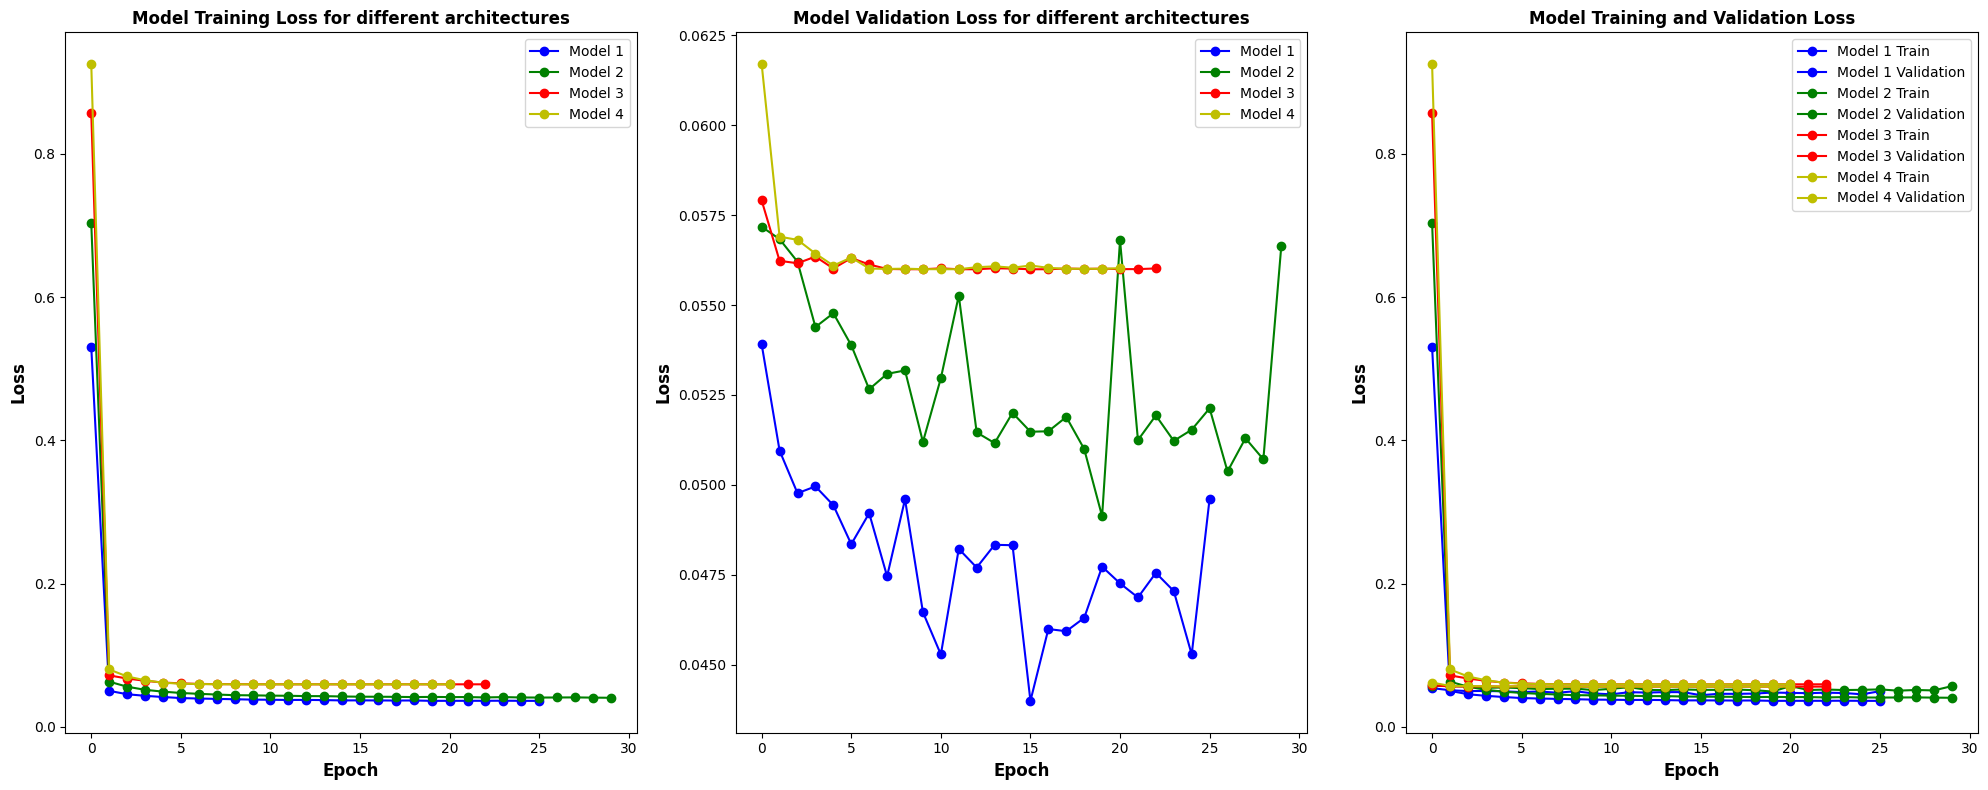

Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size
Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size


In [34]:
# Visualize training and validation loss for all models
plt.figure(figsize=(20, 8))

# Training Loss
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Training Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Validation Loss
plt.subplot(1, 3, 2)
plt.plot(history.history['val_loss'], label='Model 1', marker='o', color = 'b')
plt.plot(history2.history['val_loss'], label='Model 2', marker='o', color = 'g')
plt.plot(history3.history['val_loss'], label='Model 3', marker='o', color = 'r')
plt.plot(history4.history['val_loss'], label='Model 4', marker='o', color = 'y')
plt.title('Model Validation Loss for different architectures', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')

# Plot validation and training loss on same plot
plt.subplot(1, 3, 3)
plt.plot(history.history['loss'], label='Model 1 Train', marker='o', color = 'b')
plt.plot(history.history['val_loss'], label='Model 1 Validation', marker='o', color = 'b')
plt.plot(history2.history['loss'], label='Model 2 Train', marker='o', color = 'g')
plt.plot(history2.history['val_loss'], label='Model 2 Validation', marker='o', color = 'g')
plt.plot(history3.history['loss'], label='Model 3 Train', marker='o', color = 'r')
plt.plot(history3.history['val_loss'], label='Model 3 Validation', marker='o', color = 'r')
plt.plot(history4.history['loss'], label='Model 4 Train', marker='o', color = 'y')
plt.plot(history4.history['val_loss'], label='Model 4 Validation', marker='o', color = 'y')
plt.title('Model Training and Validation Loss', weight='bold', size=12)
plt.ylabel('Loss', weight='bold', size=12)
plt.xlabel('Epoch', weight='bold', size=12)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

# Print models
print("Model 1: 2 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 2: 3 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 3: 4 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")
print("Model 4: 5 layers, 512 nodes, adam, 50 epochs, 0.001 learning rate, 64 batch size")

#### Hyperparamaeter Tuning

In [ ]:
import itertools

# Grid Search Parameters
n_layers = [2, 3, 6]
n_nodes = [512, 1024]
optimizer = ['adam', 'sgd', 'rmsprop']
epochs = [50, 100]
learning_rate = [0.001, 0.01, 0.1]
batch_size = [64, 128]
dropout = [0.2, 0.5]
l2 = [0.01, 0.1, 0.5]
print(f"Number of combinations: {len(n_layers) * len(n_nodes) * len(optimizer) * len(epochs) * len(learning_rate) * len(batch_size)* len(dropout)* len(l2)}")

def grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y):
    # Initialize best parameters and best model variables
    best_params = None
    best_model = None
    best_score = None

    # Generate all possible combinations of hyperparameters
    param_combinations = itertools.product(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2)

    # Loop through all combinations
    for combination in param_combinations:
        # Unpack the combination
        n_layer, n_node, opt, epoch, lr, bs, dropout, l2 = combination

        # Train the model
        model, history = train_model_2(n_layer, n_node, opt, epoch, lr, bs, dropout, l2, train_x, train_y, train_plot=False, seed=10, text_embedding_dim = text_embeddings.shape[1]-3, callback=True)

        # Evaluate the model - min val loss
        min_loss = min(history.history['val_loss'])
        
        # Check if this model is better than the previous best
        if best_score is None or min_loss < best_score:
            best_score = min_loss
            best_params = combination
            best_model = model

    return best_params, best_model


# run grid search
best_params, best_model = grid_search(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2, train_x, train_y)
print(f"Best Parameters: {best_params}")

In [36]:
n_layers = 2
n_nodes = 512
optimizer = 'adam'
epochs = 200
learning_rate = 0.001
batch_size = 128
dropout = 0.5
l2_reg = 0.01

best_params = (n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, dropout, l2_reg)
best_params


(2, 512, 'adam', 200, 0.001, 128, 0.5, 0.01)

Epoch 1/200
508/508 [==============================] - 5s 8ms/step - loss: 0.5154 - val_loss: 0.0515
Epoch 2/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0489 - val_loss: 0.0504
Epoch 3/200
508/508 [==============================] - 3s 7ms/step - loss: 0.0447 - val_loss: 0.0488
Epoch 4/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0425 - val_loss: 0.0482
Epoch 5/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0409 - val_loss: 0.0474
Epoch 6/200
508/508 [==============================] - 4s 8ms/step - loss: 0.0400 - val_loss: 0.0483
Epoch 7/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0390 - val_loss: 0.0475
Epoch 8/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0386 - val_loss: 0.0480
Epoch 9/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0382 - val_loss: 0.0472
Epoch 10/200
508/508 [==============================] - 4s 7ms/step - loss: 0.0380 - val_lo

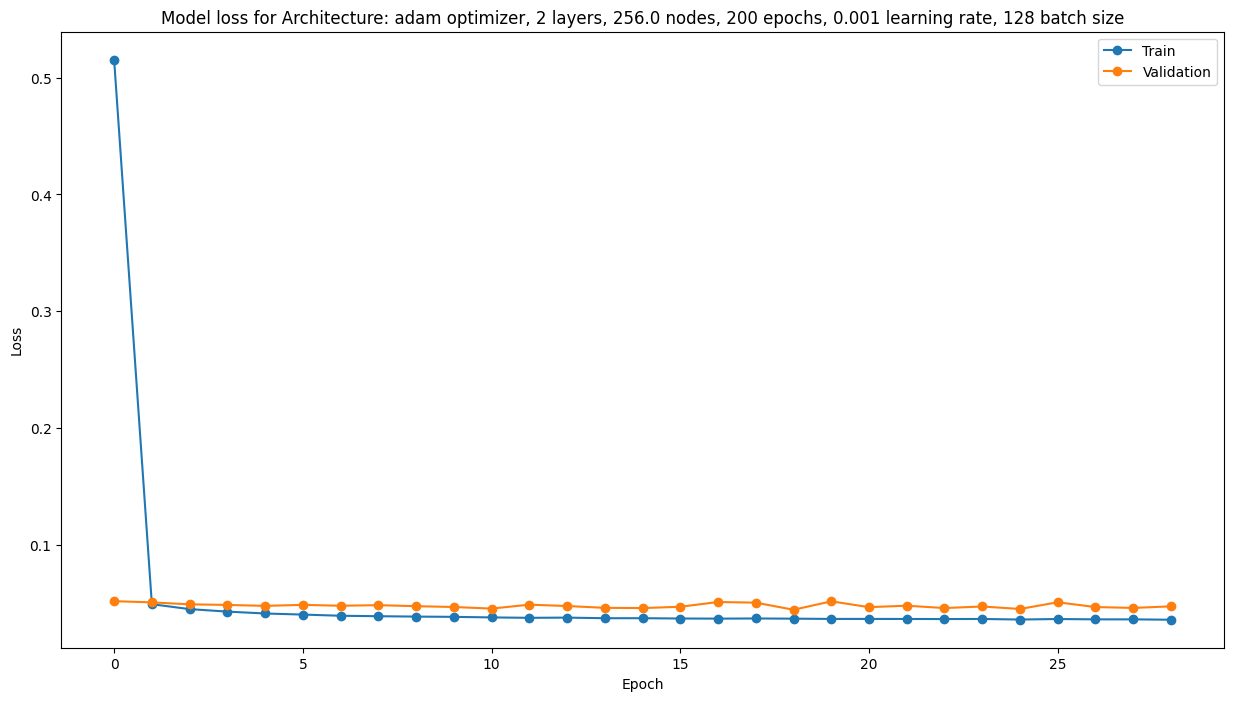

In [37]:
# fit best model 
best_model, history = train_model_3(n_layers=best_params[0], n_nodes=best_params[1], optimizer=best_params[2], epochs=best_params[3], learning_rate=best_params[4], batch_size=best_params[5], dropout=best_params[6], l2_reg=best_params[7], train_x=train_x, train_y=train_y, text_embedding_dim = text_embeddings.shape[1]-3, train_plot=True, callback=True, seed=10)

In [38]:
# MODEL EVALUATION ====================================
# Predict the ratings
y_pred = best_model.predict([test_x['user'], test_x['product'], test_x.iloc[:, 3:], test_x['sentiments']])

# Rescale the predictions back to the 1-5 range
y_pred = y_pred * 4 + 1

# set predictions and actual ratings to variables
hidden_ratings_array = (np.array(test_y)*4 + 1)
predicted_ratings_array = np.array(y_pred).flatten()

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv("Data/Results/NCF_results_3.csv", index=False)
results

344/344 [==============================] - 1s 2ms/step

Rating Metrics
Mean Absolute Error (MAE): 0.5290225445899215
Mean Squared Error (MSE): 0.6065956156389717
Root Mean Squared Error (RMSE): 0.7788424844851312


,MAE,MSE,RMSE
0,0.529,0.607,0.779


## Model 4: Naive Model

We want to build a **naive benchmark model to compare with our NCF model**. The benchmark model will predict the rating of a user-item pair as:

1. the most popular rating in the training set. For example, if the most popular rating in the training set is 4, then the benchmark model will predict the rating of all user-item pairs as 4.

***TLDR***: The benchmark model, which predicts a constant value (5) for all ratings, outperforms the NCF model in terms of rating metrics and some classification metrics. The NCF model, while providing reasonable results, might need further optimization or tuning to improve its performance, especially in terms of rating prediction.


In [39]:
# Benchmark Model 1 (make it all 5s) ====================================
benchmark_results_1 = predicted_ratings_array.copy()
benchmark_results_1.fill(5)

In [40]:
# evaluate benchmark model 1 ====================================
predicted_ratings_array = benchmark_results_1

# Rating predictions
mae = mean_absolute_error(hidden_ratings_array, predicted_ratings_array)
mse = mean_squared_error(hidden_ratings_array, predicted_ratings_array)
rmse = np.sqrt(mse)
print("\nRating Metrics")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")

# save results to csv
results = pd.DataFrame({'MAE': [mae.round(3)], 'MSE': [mse.round(3)], 'RMSE': [rmse.round(3)]})
results.to_csv("Data/Results/NCF_results_benchmark.csv", index=False)
results


Rating Metrics
Mean Absolute Error (MAE): 0.5822428207924392
Mean Squared Error (MSE): 1.269629225736096
Root Mean Squared Error (RMSE): 1.1267782504717136


,MAE,MSE,RMSE
0,0.582,1.27,1.127


# Extra

Querying ChatGPT

I am doing a project on building a neural collaborative filtering recommender system using amazon product review data. I want the recommender system to use the user ratings for items and the user review text. I have the following function for NCF using ratings and review text:
def train_model(n_layers, n_nodes, optimizer, epochs, learning_rate, batch_size, train_x, train_y, review_text_embeddings, seed=2207):
    np.random.seed(seed)
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    product_input = Input(shape=(1,), dtype='int32', name='product_input')
    text_input = Input(shape=(text_embedding_dim,), dtype='float32', name='text_input')  # Text embeddings

    user_embedding = Embedding(input_dim=len(data_hidden['user'].cat.categories), output_dim=50, name='user_embedding')(user_input)
    product_embedding = Embedding(input_dim=len(data_hidden['product'].cat.categories), output_dim=50, name='product_embedding')(product_input)

    user_vecs = Flatten()(user_embedding)
    product_vecs = Flatten()(product_embedding)

    input_vecs = Concatenate()([user_vecs, product_vecs, text_input])

    x = input_vecs
    for i in range(n_layers):
        if i == 0:
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
        else:
            n_nodes = n_nodes/2
            x = Dense(n_nodes, activation='relu')(x)
            x = Dropout(0.2)(x)
    y = Dense(1)(x)

    model = Model(inputs=[user_input, product_input, text_input], outputs=y)
    # ...
    if optimizer == 'adam':
        opt = Adam(learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate)
    model.compile(optimizer=opt, loss='mse')

    history = model.fit([train_x['user'], train_x['product']], train_y, batch_size=batch_size, epochs=epochs, validation_split=0.1)
    
    return model, history

How does it look?

Now this is the code I have done for preprocessing the ratings that each user has given for each item: x_hidden = data.copy()
indices_tracker = []
N = 3
np.random.seed(2207) 
for user_id in range(x_hidden.shape[0]):
    rated_products = np.where(x_hidden.iloc[user_id, :] > 0)[0]
    # print("User:", user_id)
    # print("Indices of Rated Products:", rated_products)
    hidden_indices = np.random.choice(rated_products, N, replace=False)
    indices_tracker.append(hidden_indices)
    # print("Indices to Hide:", hidden_indices, "\n")
    x_hidden.iloc[user_id, hidden_indices] = 'Hidden'

test_data = x_hidden.copy()
test_data = test_data.reset_index()
test_data = test_data.melt(id_vars=test_data.columns[0], var_name='book', value_name='rating')
test_data.columns = ['user', 'product', 'rating']
indices_hidden = test_data[test_data['rating'] == 'Hidden'].index

data_hidden = x_hidden.reset_index()
data_hidden = data_hidden.melt(id_vars=data_hidden.columns[0], var_name='product', value_name='rating')
data_hidden.iloc[indices_hidden, 2] = np.nan
data_hidden.columns = ['user', 'product', 'rating']
data_hidden = data_hidden[data_hidden['rating'].notna()]
data_hidden['user'] = data_hidden['user'].astype('category')
data_hidden['product'] = data_hidden['product'].astype('category')

train_x = data_hidden[['user', 'product']].apply(lambda x: x.cat.codes)
train_y = data_hidden['rating'].astype(np.float64)
train_y = (train_y - 1) / 4

copy = x.copy()
copy = copy.reset_index()
copy = copy.melt(id_vars=copy.columns[0], var_name='product', value_name='rating')
copy.columns = ['user', 'product', 'rating']
test_x = copy.iloc[indices_hidden, 0:2]
test_x['user'] = test_x['user'].astype('category')
test_x['product'] = test_x['product'].astype('category')
test_x = test_x.apply(lambda x: x.cat.codes)
test_y = copy.iloc[indices_hidden, 2].astype(np.float64)
test_y = (test_y - 1) / 4

How can i adjust this code to also include and preprocess my review text data which is stored in 'data'.